In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.integrate
import scipy.interpolate
import pandas as pd

pi = np.pi
MeV_to_km = 1.323e-6
Mo_to_km = 1.4766

p_c = 4.42e-5 # km^-2

In [2]:
# read in our EOS data
# The files contain n[0.16 fm^-3], p[Mev/fm^-3] and eps [Mev/fm^-3]

EOS_1 = pd.read_table('../data/3952.dat', header=None)
EOS_2 = pd.read_table('../data/8663.dat', header=None)
EOS_3 = pd.read_table('../data/13022.dat', header=None)

# grab p and e then convert them to km^-2

p_1 = MeV_to_km*EOS_1[1].to_numpy()
e_1 = MeV_to_km*EOS_1[2].to_numpy()

p_2 = MeV_to_km*EOS_2[1].to_numpy()
e_2 = MeV_to_km*EOS_2[2].to_numpy()

p_3 = MeV_to_km*EOS_3[1].to_numpy()
e_3 = MeV_to_km*EOS_3[2].to_numpy()

The conversion from MeV/fm^3 to km^-2 is taken from "TOV_notes".

$$ 1 \frac{\text{MeV}}{\text{fm}^3} \frac{G}{c^4} = 1.323 \times 10^{-6} \text{ km}^{-2} $$

In [3]:
def k_2(C, x_R):
    num = ((1 - 2*C)**2)*(2 - x_R + 2*C*(x_R-1))
    
    a = 6 - 3*x_R + 3*C*(5*x_R - 8)
    b = 13 - 11*x_R + C*(3*x_R-2) + (2*C**2)*(1+x_R)
    c = 2 - x_R + 2*C*(x_R-1)
    
    den = 2*C*a + 4*(C**3)*b + 3*((1-2*C)**2)*c*np.log(1-2*C)
    
    return (8*(C**5)*num)/(5*den)

def big_lamb(k2, R, M):
    """
    k2: dimensionless tidal Love number
    R: radius of NS in km
    M: mass of NS in Mo (solar masses)
    """
    return (2/3)*k2*((R/(1.4766*M))**5)

In [4]:
def ODE(y, p, EOS_e):
    """
    Function that characterizes the ODE we are solving.
    """
    
    dy = np.zeros(y.shape)
    
    num0 = -2*y[0]*(np.sqrt(y[0])-2*y[1])
    den0 = (EOS_e(p)+p)*(y[1]+4*pi*p*y[0]**(3/2))
    
    dy[0] = num0/den0
    
    num1 = -4*np.pi*EOS_e(p)*(y[0]**(3/2))*(np.sqrt(y[0])-2*y[1])
    den1 = (EOS_e(p)+p)*(y[1]+4*pi*p*y[0]**(3/2))
    
    dy[1] = num1/den1
    
    return dy

def ODE_2(y, p, EOS_e):
    """
    Function that characterizes the ODE we are solving.
    """
    
    dy = np.zeros(y.shape)
    
    num0 = -2*y[0]*(np.sqrt(y[0])-2*y[1])
    den0 = (EOS_e(p)+p)*(y[1]+4*pi*p*y[0]**(3/2))
    
    dy[0] = num0/den0
    
    num1 = -4*np.pi*EOS_e(p)*(y[0]**(3/2))*(np.sqrt(y[0])-2*y[1])
    den1 = (EOS_e(p)+p)*(y[1]+4*pi*p*y[0]**(3/2))
    
    dy[1] = num1/den1
    
    num2 = (y[2]**2 + y[2]*F_ode(p, y[0], y[1], EOS_e)
            + yQ_ode(p, y[0], y[1], EOS_e) )*(np.sqrt(y[0])-2*y[1])
    den2 = (EOS_e(p)+p)*(y[1]+4*pi*p*y[0]**(3/2))
    
    dy[2] = num2/den2
    
    return dy

In [5]:
def F_ode(p, y, m, EOS_e):
    
    a = np.sqrt(y)/(np.sqrt(y)-2*m)
    b = 4*pi*(EOS_e(p)-p)
    return a*(1-b)

def yQ_ode(p, y, m, EOS_e):
        
    a = 4*pi*y*np.sqrt(y)
    b = np.sqrt(y)-2*m
    
    one = (a/b)*(5*EOS_e(p) + 9*p + EOS_e.derivative(nu=1)(p)*(EOS_e(p)+p))
    two = -6*np.sqrt(y)/b
    three = -4*( m/b + a*p/b )**2
    
    return one+two+three

In [6]:
def solve_tov_MR(central_ps, EOS_e):
    
    data = np.zeros((central_ps.shape[0],3)) # (p_c, radius_km, mass_Mo)

    i = 0
    for pc in central_ps:
        t0 = pc
        y0 = np.array([1e-10,1e-10])
        tf = 1e-10*t0

        size = int(1e3)
        t = np.linspace(t0, tf, size)

        sol = scipy.integrate.odeint(ODE, y0, t, args=(EOS_e,))

        data[i,0] = pc/MeV_to_km
        data[i,1] = max(np.sqrt(sol[:,0]))
        data[i,2] = max(sol[:,1]/1.4766)
        
        i+=1

    return data

def plot_MRL(data):
    
    """
    Function to plot data from solvers
    
    data = (pc_MeV/fm3, radius_km, mass_Mo, Lambda)
    data.shape = (size, 3 or 4)
    """
    
    if data.shape[1]==3:
    
        fig, ax = plt.subplots(1,3, figsize=(18,6))

        ax[0].plot( data[:,0], data[:,1])
        ax[0].set_xlabel('Pressure (MeV/fm^3)')
        ax[0].set_ylabel('Radius (km)')

        ax[1].plot( data[:,0], data[:,2])
        ax[1].set_xlabel('Pressure (MeV/fm^3)')
        ax[1].set_ylabel('Mass (Mo)')

        ax[2].plot(data[:,1], data[:,2])
        ax[2].set_xlabel('Radius (km)')
        ax[2].set_ylabel('Mass (Mo)')
    
    elif data.shape[1]==4:
            
        fig, ax = plt.subplots(2,2, figsize=(12,12))

        ax[0,0].plot(data[:,0], data[:,1])
        ax[0,0].set_xlabel('Pressure (MeV/fm^3)')
        ax[0,0].set_ylabel('Radius (km)')

        ax[0,1].plot(data[:,0], data[:,2])
        ax[0,1].set_xlabel('Pressure (MeV/fm^3)')
        ax[0,1].set_ylabel('Mass (Mo)')

        ax[1,0].plot(data[:,2], data[:,3])
        ax[1,0].set_xlabel('Mass (Mo)')
        ax[1,0].set_ylabel('$\Lambda$')

        ax[1,1].plot(data[:,1], data[:,2])
        ax[1,1].set_xlabel('Radius (km)')
        ax[1,1].set_ylabel('Mass (Mo)')
        
    else:
        print('The data given is not correct or given in the wrong form.')
        
def solve_tov_MRL(central_ps, EOS_e):
    
    data = np.zeros((central_ps.shape[0],4)) # (p_c, radius_km, mass_Mo, Lambda)

    i = 0
    for pc in central_ps:
        t0 = pc
        y0 = np.array( [1e-9, 1e-12, 2] )
        tf = 1e-10*t0

        size = int(1e3)
        t = np.linspace(t0, tf, size)

        sol = scipy.integrate.odeint(ODE_2, y0, t, args=(EOS_e,))

        data[i,0] = pc/MeV_to_km
        data[i,1] = max(np.sqrt(sol[:,0]))
        data[i,2] = max(sol[:,1]/1.4766)
        
        x_R = sol[-1,2]
        C = Mo_to_km*data[i,2]/data[i,1]
        k2 = k_2(C, x_R)

        data[i,3] = big_lamb(k2, data[i,1], data[i,2])
        
        i+=1

    return data

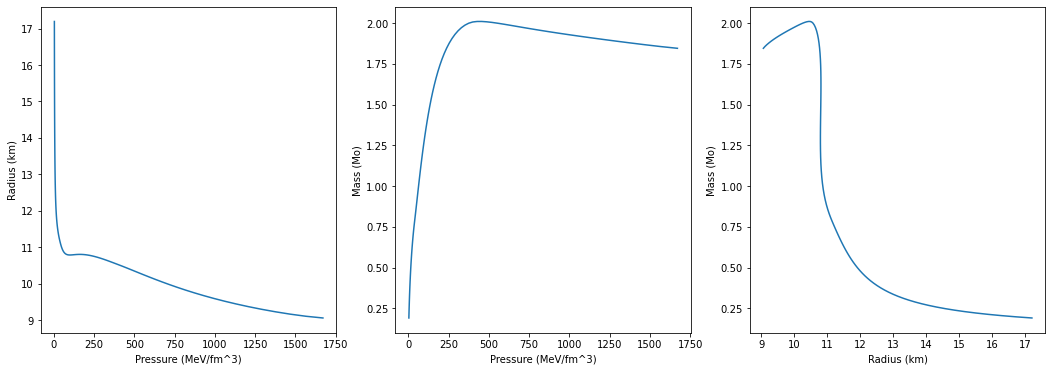

In [7]:
size = 100
start = np.log(8e-2) # start/stop for log spacing
stop = np.log(5e1)
pcs = p_c*np.e**(np.linspace(start, stop, size)) # central pressures in km^-2

# max p_c ~ 3000 MeV/fm^3

# we must redefine the interpolation everytime because we have def EOSs
EOS1_e = scipy.interpolate.CubicSpline(p_1, e_1)
# func_de = scipy.interpolate.CubicSpline(p_1, e_1).derivative(nu=1)

MR_3952 = solve_tov_MR(pcs, EOS1_e)
np.savetxt('3952_MRcurve', MR_3952)
plot_MRL(MR_3952)

/opt/anaconda3/lib/python3.8/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


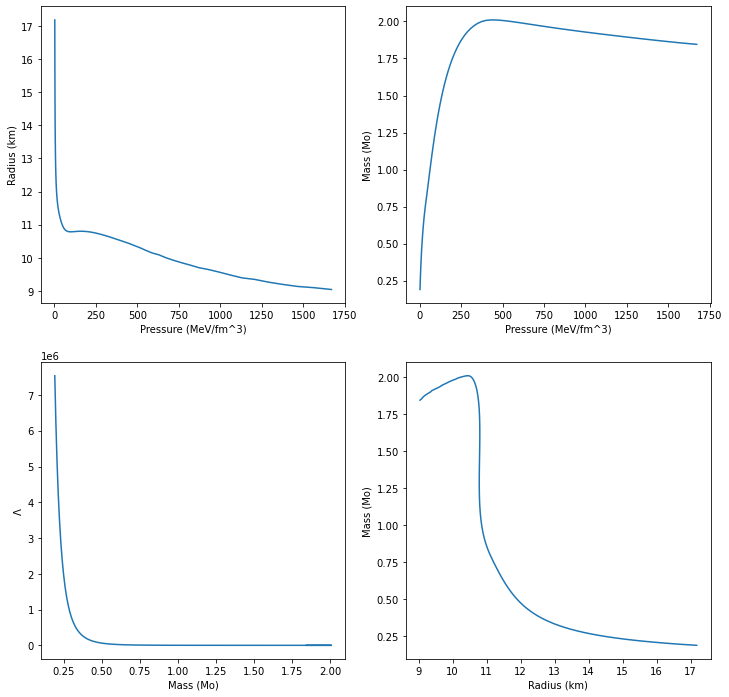

In [8]:
MRL_3952 = solve_tov_MRL(pcs, EOS1_e)
np.savetxt('3952_MRLcurve', MRL_3952)
plot_MRL(MRL_3952)

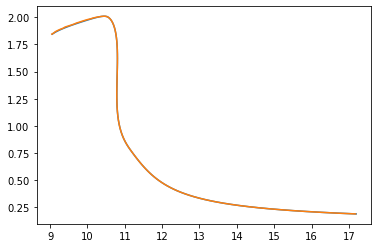

In [9]:
plt.plot(MR_3952[:,1], MR_3952[:,2])
plt.plot(MRL_3952[:,1], MRL_3952[:,2])

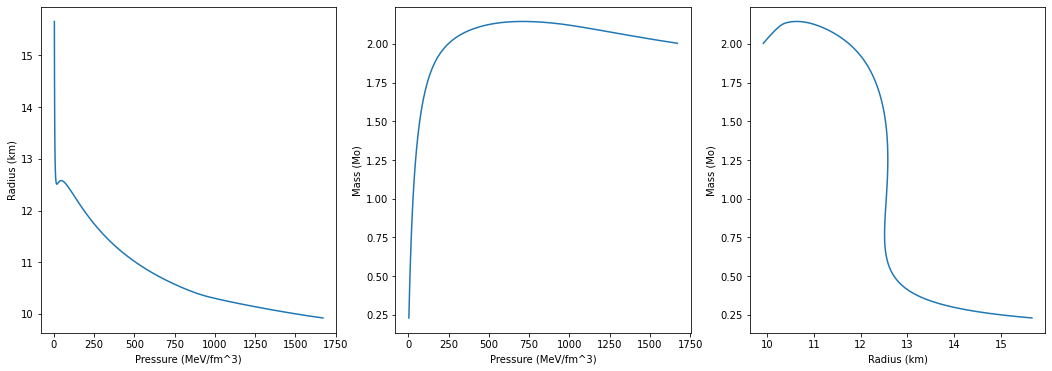

In [10]:
size = 100
start = np.log(1e-1) # start/stop for log spacing
stop = np.log(5e1)
pcs = p_c*np.e**(np.linspace(start, stop, size)) # central pressures in km^-2

# max p_c ~ 3000 MeV/fm^3

EOS2_e = scipy.interpolate.CubicSpline(p_2, e_2)

MR_8663 = solve_tov_MR(pcs, EOS2_e)
np.savetxt('8663_MRcurve', MR_8663)
plot_MRL(MR_8663)

/opt/anaconda3/lib/python3.8/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


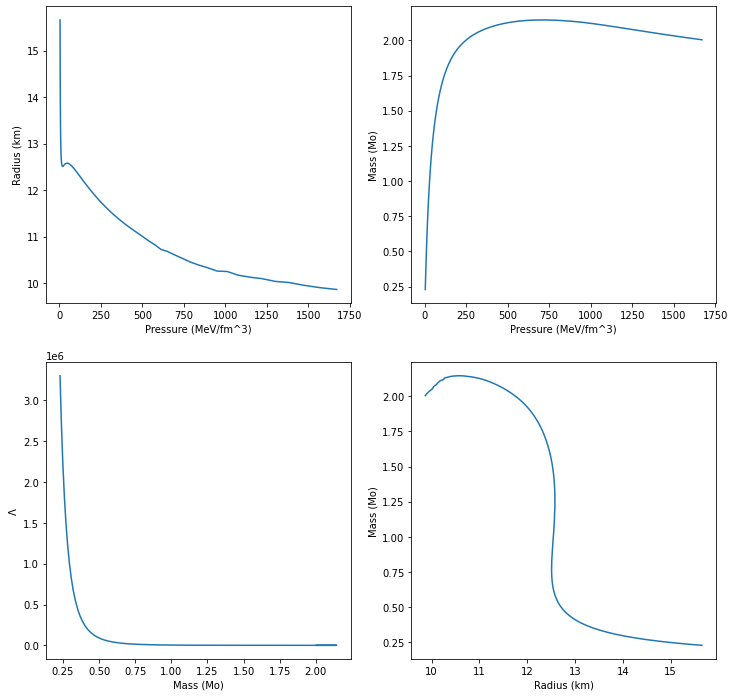

In [11]:
MRL_8663 = solve_tov_MRL(pcs, EOS2_e)
np.savetxt('8663_MRLcurve', MRL_8663)
plot_MRL(MRL_8663)

/opt/anaconda3/lib/python3.8/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


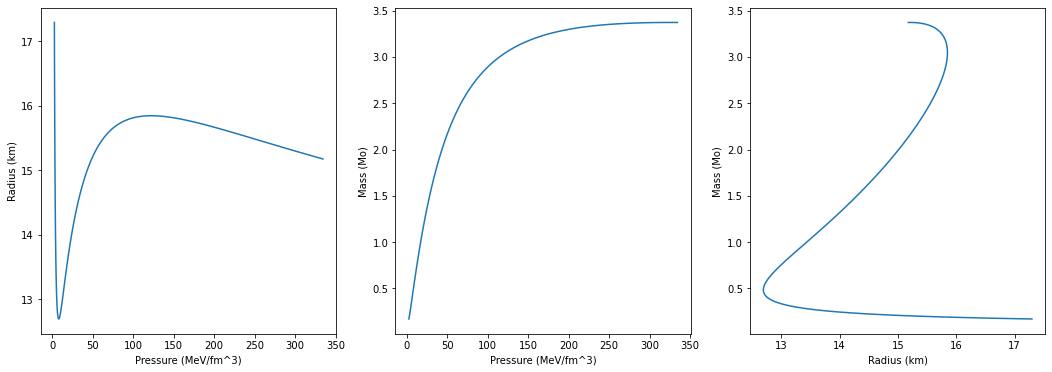

In [12]:
size = 100
start = np.log(8e-2) # start/stop for log spacing
stop = np.log(1e1)
pcs = p_c*np.e**(np.linspace(start, stop, size)) # central pressures in km^-2

# max p_c ~ 3000 MeV/fm^3

EOS3_e = scipy.interpolate.CubicSpline(p_3, e_3)

MR_13022 = solve_tov_MR(pcs, EOS3_e)
np.savetxt('13022_MRcurve', MR_13022)
plot_MRL(MR_13022)

/opt/anaconda3/lib/python3.8/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


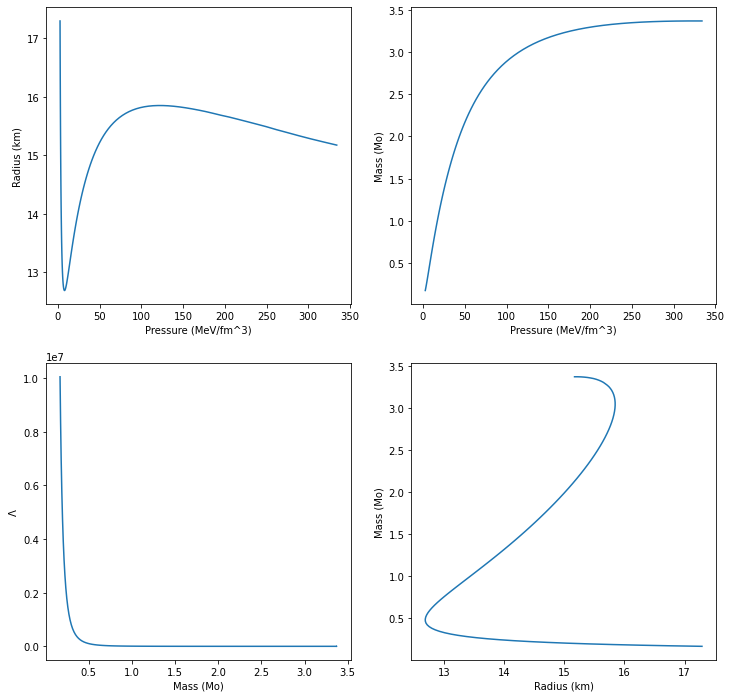

In [13]:
MRL_13022 = solve_tov_MRL(pcs, EOS3_e)
np.savetxt('13022_MRLcurve', MRL_13022)
plot_MRL(MRL_13022)

In [14]:
# let's check my answers with Ingo's

ingo_3952 = pd.read_table('../data/ingo_3952.dat', header=None).to_numpy()
ingo_8663 = pd.read_table('../data/ingo_8663.dat', header=None).to_numpy()
ingo_13022 = pd.read_table('../data/ingo_13022.dat', header=None).to_numpy()

print(ingo_3952.shape) # (radius [km], mass [Mo], Lambda [arb], cental baryon density [idk])

(111, 4)


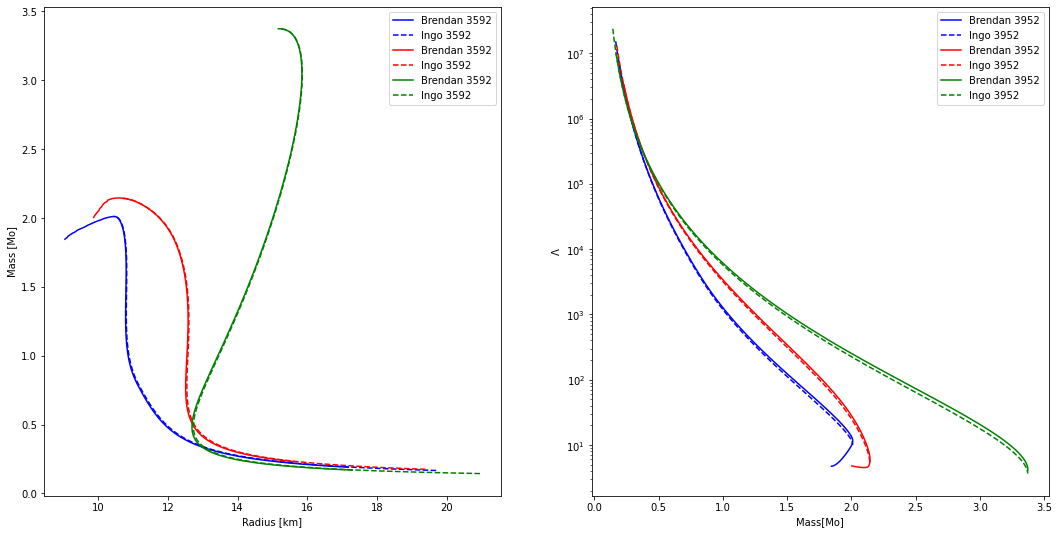

In [15]:
fig, ax = plt.subplots(1,2, figsize=(18,9))

ax[0].plot(MRL_3952[:,1], MRL_3952[:,2], color='b', ls='-', label='Brendan 3592')
ax[0].plot(ingo_3952[:,0], ingo_3952[:,1], color='b', ls='--', label='Ingo 3592')

ax[1].plot(MRL_3952[:,2], MRL_3952[:,3], color='b', ls='-', label='Brendan 3952')
ax[1].plot(ingo_3952[:,1], ingo_3952[:,2], color='b', ls='--', label='Ingo 3952')

ax[0].plot(MRL_8663[:,1], MRL_8663[:,2], color='r', ls='-', label='Brendan 3592')
ax[0].plot(ingo_8663[:,0], ingo_8663[:,1], color='r', ls='--', label='Ingo 3592')

ax[1].plot(MRL_8663[:,2], MRL_8663[:,3], color='r', ls='-', label='Brendan 3952')
ax[1].plot(ingo_8663[:,1], ingo_8663[:,2], color='r', ls='--', label='Ingo 3952')

ax[0].plot(MRL_13022[:,1], MRL_13022[:,2], color='g', ls='-', label='Brendan 3592')
ax[0].plot(ingo_13022[:,0], ingo_13022[:,1], color='g', ls='--', label='Ingo 3592')

ax[1].plot(MRL_13022[:,2], MRL_13022[:,3], color='g', ls='-', label='Brendan 3952')
ax[1].plot(ingo_13022[:,1], ingo_13022[:,2], color='g', ls='--', label='Ingo 3952')

ax[0].set_xlabel('Radius [km]')
ax[0].set_ylabel('Mass [Mo]')
ax[0].legend()
ax[1].set_xlabel('Mass[Mo]')
ax[1].set_ylabel('$\Lambda$')
ax[1].set_yscale('log')
ax[1].legend()

In [28]:
def remove_high_mass(data):
    
    max_index = np.argmax(data[:,2])
    clean_data = data[:max_index+1,:]
        
    return clean_data

In [29]:
MRL_3952_clean = remove_high_mass(MRL_3952)
MRL_8663_clean = remove_high_mass(MRL_8663)
MRL_13022_clean = remove_high_mass(MRL_13022)

print(MRL_8663_clean.shape, MRL_8663.shape)

(86, 4) (100, 4)


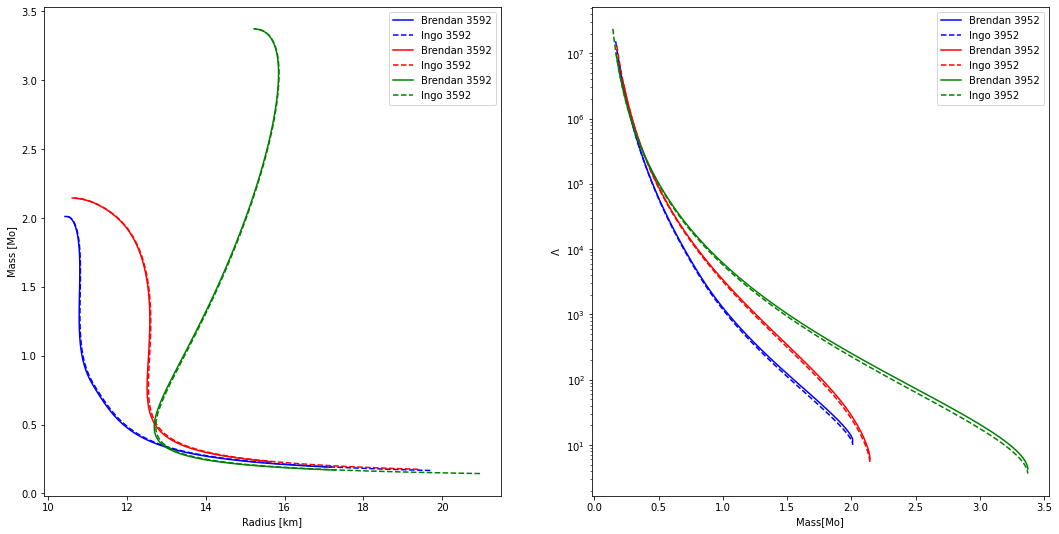

In [30]:
fig, ax = plt.subplots(1,2, figsize=(18,9))

ax[0].plot(MRL_3952_clean[:,1], MRL_3952_clean[:,2], color='b', ls='-', label='Brendan 3592')
ax[0].plot(ingo_3952[:,0], ingo_3952[:,1], color='b', ls='--', label='Ingo 3592')

ax[1].plot(MRL_3952_clean[:,2], MRL_3952_clean[:,3], color='b', ls='-', label='Brendan 3952')
ax[1].plot(ingo_3952[:,1], ingo_3952[:,2], color='b', ls='--', label='Ingo 3952')

ax[0].plot(MRL_8663_clean[:,1], MRL_8663_clean[:,2], color='r', ls='-', label='Brendan 3592')
ax[0].plot(ingo_8663[:,0], ingo_8663[:,1], color='r', ls='--', label='Ingo 3592')

ax[1].plot(MRL_8663_clean[:,2], MRL_8663_clean[:,3], color='r', ls='-', label='Brendan 3952')
ax[1].plot(ingo_8663[:,1], ingo_8663[:,2], color='r', ls='--', label='Ingo 3952')

ax[0].plot(MRL_13022_clean[:,1], MRL_13022_clean[:,2], color='g', ls='-', label='Brendan 3592')
ax[0].plot(ingo_13022[:,0], ingo_13022[:,1], color='g', ls='--', label='Ingo 3592')

ax[1].plot(MRL_13022_clean[:,2], MRL_13022_clean[:,3], color='g', ls='-', label='Brendan 3952')
ax[1].plot(ingo_13022[:,1], ingo_13022[:,2], color='g', ls='--', label='Ingo 3952')

ax[0].set_xlabel('Radius [km]')
ax[0].set_ylabel('Mass [Mo]')
ax[0].legend()
ax[1].set_xlabel('Mass[Mo]')
ax[1].set_ylabel('$\Lambda$')
ax[1].set_yscale('log')
ax[1].legend()